In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import lines as mlines
import os
from astropy.table import Table

In [2]:
from read_sfh import get_scales
small_file_fname = "/Users/aphearin/Dropbox/UniverseMachine/data/histories/small_sfh_catalog_1.002310.txt"
scale_factor_array = get_scales(small_file_fname)
cosmic_age_array = np.load('/Users/aphearin/Dropbox/UniverseMachine/data/histories/prelim_sfh_reduction/times.npy')

In [3]:
from assemble_catalog import assemble_catalog as assemble_history_data

snapshot_root_dirname = "/Users/aphearin/Dropbox/UniverseMachine/data/binary_reductions/z0/binaries/"
num_subvols = 144
history_cols = ('halo_id', 'halo_upid', 'halo_mpeak', 'halo_vmax_at_mpeak', 
                'stellar_mass', 'sfr', 'sfr_mp', 'sm_mp')
histories = Table(assemble_history_data(snapshot_root_dirname, num_subvols, *history_cols))

In [4]:
from quenching_time import quenching_time
histories['quenching_time'] = quenching_time(histories['sfr_mp'], histories['sm_mp'])

In [6]:
from halocat_binary_reduction import assemble_halocat, read_column_info_array

halocat_binary_dirname = "/Users/aphearin/Dropbox/UniverseMachine/data/halocat_snapshot/a_1.00231"
column_info_fname = os.path.join(os.path.dirname(halocat_binary_dirname), 'column_info.dat')
column_info_array = read_column_info_array(column_info_fname)
propnames = ('halo_id', 'first_acc_scale', 'acc_rate_1tdyn', 'mpeak_scale', 'delta_vmax_tdyn_behroozi16', 
            'x', 'y', 'z', 'vx', 'vy', 'vz')
halo_table = Table(assemble_halocat(halocat_binary_dirname, column_info_array, *propnames))
print("Available columns = \n{0}\n".format(halo_table.keys()))
print("number of halos in snapshot = {0}".format(len(halo_table)))

Available columns = 
['halo_id', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'acc_rate_1tdyn', 'mpeak_scale', 'first_acc_scale', 'delta_vmax_tdyn_behroozi16']

number of halos in snapshot = 12085858


In [8]:
from halotools.utils import crossmatch
idxA, idxB = crossmatch(histories['halo_id'].data, halo_table['halo_id'].data)
histories = histories[idxA]

keys_to_add = ('x', 'y', 'z', 'vx', 'vy', 'vz', 
               'first_acc_scale', 'acc_rate_1tdyn', 'mpeak_scale', 
               'delta_vmax_tdyn_behroozi16')
for key in keys_to_add:
    histories[key] = halo_table[key][idxB]

In [9]:
histories['time_first_acc'] = np.interp(histories['first_acc_scale'], scale_factor_array, cosmic_age_array)
histories['host_mpeak'] = histories['halo_mpeak']

In [10]:
from history_functions import ssfr_at_infall

histories['ssfr_at_infall'] = ssfr_at_infall(histories['sfr_mp'].data, 
                                histories['sm_mp'].data, histories['time_first_acc'].data)

satmask = histories['halo_upid'] != -1
sats = histories[satmask]
cens = histories[~satmask]

idxA, idxB = crossmatch(sats['halo_upid'], histories['halo_id'])
sats['host_mpeak'][idxA] = histories['halo_mpeak'][idxB]
histories['host_mpeak'][satmask] = sats['host_mpeak']

quenched_satmask = np.log10(sats['sfr']/sats['stellar_mass']) < -11
quenched_sats = sats[quenched_satmask]

# Plot fraction that quenched after infall

In [42]:
# time_first_acc
# ssfr_at_infall

In [55]:
logsm_low, logsm_high, num_sm_bins = 9.5, 11.5, 15
sm_bins = np.logspace(logsm_low, logsm_high, num_sm_bins)
sm_mids = 10**((np.log10(sm_bins)[1:] + np.log10(sm_bins)[:-1])/2.)

host_mass_bins = [10**12, 10**13, 10**14, np.inf]

infall_time = np.zeros(len(sm_bins)-1)
infall_time_variance = np.zeros(len(sm_bins)-1)
infall_time_milky_way = np.zeros(len(sm_bins)-1)
infall_time_group = np.zeros(len(sm_bins)-1)
infall_time_cluster = np.zeros(len(sm_bins)-1)
#
ssfr_at_infall = np.zeros(len(sm_bins)-1)
ssfr_at_infall_variance = np.zeros(len(sm_bins)-1)
ssfr_at_infall_milky_way = np.zeros(len(sm_bins)-1)
ssfr_at_infall_group = np.zeros(len(sm_bins)-1)
ssfr_at_infall_cluster = np.zeros(len(sm_bins)-1)


for i, sm_low, sm_high in zip(range(len(sm_bins)-1), sm_bins[0:-1], sm_bins[1:]):
    sm_bin_mask = (sats['stellar_mass'] > sm_low) & (sats['stellar_mass'] < sm_high)
    infall_time[i] = np.mean(sats['time_first_acc'][sm_bin_mask])
    infall_time_variance[i] = np.std(sats['time_first_acc'][sm_bin_mask])
    ssfr_at_infall[i] = np.mean(sats['ssfr_at_infall'][sm_bin_mask])
    ssfr_at_infall_variance[i] = np.std(sats['ssfr_at_infall'][sm_bin_mask])
    
    milky_way_sm_bin_mask = sm_bin_mask*(sats['host_mpeak'] > host_mass_bins[0])*(sats['host_mpeak'] < host_mass_bins[1])
    infall_time_milky_way[i] = np.mean(sats['time_first_acc'][milky_way_sm_bin_mask])
    ssfr_at_infall_milky_way[i] = np.mean(sats['ssfr_at_infall'][milky_way_sm_bin_mask])

    group_sm_bin_mask = sm_bin_mask*(sats['host_mpeak'] > host_mass_bins[1])*(sats['host_mpeak'] < host_mass_bins[2])
    infall_time_group[i] = np.mean(sats['time_first_acc'][group_sm_bin_mask])
    ssfr_at_infall_group[i] = np.mean(sats['ssfr_at_infall'][group_sm_bin_mask])

    cluster_sm_bin_mask = sm_bin_mask*(sats['host_mpeak'] > host_mass_bins[2])*(sats['host_mpeak'] < host_mass_bins[3])
    infall_time_cluster[i] = np.mean(sats['time_first_acc'][cluster_sm_bin_mask])
    ssfr_at_infall_cluster[i] = np.mean(sats['ssfr_at_infall'][cluster_sm_bin_mask])


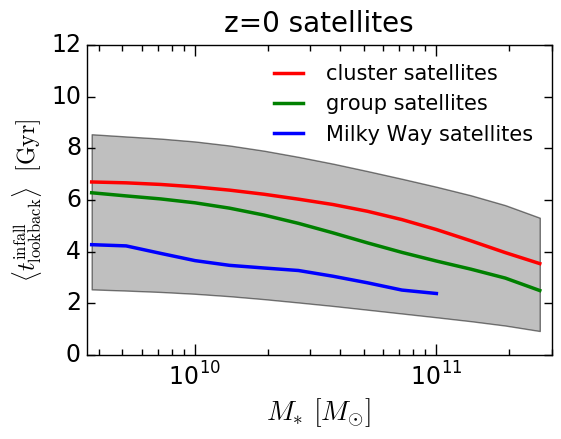

In [56]:
from scipy.signal import savgol_filter

fig = plt.figure()
ax = fig.add_subplot(111)

xlabel = ax.set_xlabel(r'$M_{\ast}$ $[M_{\odot}]$', fontsize=20)
ylabel = ax.set_ylabel(r'$\langle t_{\rm lookback}^{\rm infall}\rangle$  ${\rm [Gyr]}$', fontsize=17)
title = ax.set_title('z=0 satellites', fontsize=20, y=1.02) # y param fixes an overhanging title

ax.plot(sm_mids, savgol_filter(cosmic_age_array[-1] - infall_time_cluster, 13, 5), color='red', 
        linewidth=2.5, label = "cluster satellites")

ax.plot(sm_mids, savgol_filter(cosmic_age_array[-1] - infall_time_group, 13, 5), color='green', 
        linewidth=2.5, label = "group satellites")

y1 = savgol_filter(cosmic_age_array[-1] - infall_time - infall_time_variance, 13, 5)
y2 = savgol_filter(cosmic_age_array[-1] - infall_time + infall_time_variance, 13, 5)
ax.fill_between(sm_mids, y1, y2, facecolor='gray', alpha=0.5)

ax.plot(sm_mids[:-3], savgol_filter(cosmic_age_array[-1] - infall_time_milky_way, 13, 5)[:-3], color='blue', 
        linewidth=2.5, label = "Milky Way satellites")

plt.tick_params(axis='x', length=8, width=1, which='major') 
plt.tick_params(axis='x', length=4, width=1, which='minor') 
plt.tick_params(axis='y', length=6, width=1, which='major') 
plt.xscale('log')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.xlim(xmin = 10**9.55, xmax=3*10**11)
plt.ylim(ymin = 0, ymax = 12)
plt.legend(frameon=False, loc='upper right', fontsize=15)

fig.savefig('FIGS/infall_time_comparison.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

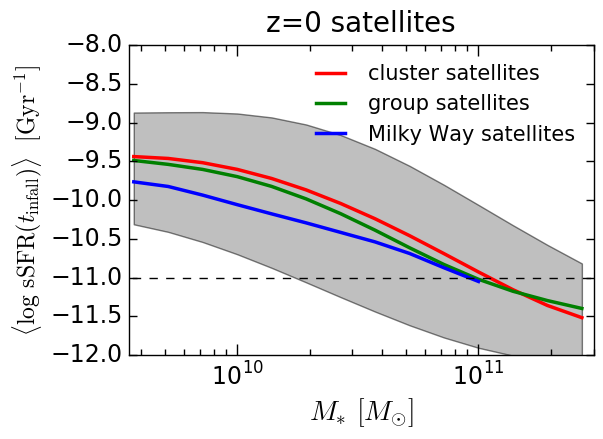

In [70]:
fig = plt.figure()
ax = fig.add_subplot(111)

xlabel = ax.set_xlabel(r'$M_{\ast}$ $[M_{\odot}]$', fontsize=20)
ylabel = ax.set_ylabel(r'$\langle \log$ $ {\rm sSFR}(t_{\rm infall})\rangle$  $[{\rm Gyr}^{-1}]$', fontsize=17)
title = ax.set_title('z=0 satellites', fontsize=20, y=1.02) # y param fixes an overhanging title

# ax.plot(sm_mids, savgol_filter(cosmic_age_array[-1] - infall_time_cluster, 13, 5), color='red', 
#         linewidth=2.5, label = "cluster satellites")

# ax.plot(sm_mids, savgol_filter(cosmic_age_array[-1] - infall_time_group, 13, 5), color='green', 
#         linewidth=2.5, label = "group satellites")

y1 = savgol_filter(ssfr_at_infall - ssfr_at_infall_variance, 13, 5)
y2 = savgol_filter(ssfr_at_infall + ssfr_at_infall_variance, 13, 5)
ax.fill_between(sm_mids, y1, y2, facecolor='gray', alpha=0.5)

# ax.plot(sm_mids, savgol_filter(ssfr_at_infall, 13, 5), color='k', 
#         linewidth=2.5, label = "all satellites")

ax.plot(sm_mids, savgol_filter(ssfr_at_infall_cluster, 13, 5), color='red', 
        linewidth=2.5, label = "cluster satellites")
ax.plot(sm_mids, savgol_filter(ssfr_at_infall_group, 13, 5), color='green', 
        linewidth=2.5, label = "group satellites")
ax.plot(sm_mids[:-3], savgol_filter(ssfr_at_infall_milky_way, 13, 5)[:-3], color='blue', 
        linewidth=2.5, label = "Milky Way satellites")

ax.plot(np.logspace(8, 13, 100), np.zeros(100)-11, '--', color='k')

plt.tick_params(axis='x', length=8, width=1, which='major') 
plt.tick_params(axis='x', length=4, width=1, which='minor') 
plt.tick_params(axis='y', length=6, width=1, which='major') 
plt.xscale('log')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.xlim(xmin = 10**9.55, xmax=3*10**11)
plt.ylim(ymin = -12, ymax = -8)
plt.legend(frameon=False, loc='upper right', fontsize=15)


8.6291376940823028